<a href="https://colab.research.google.com/github/Maria-Hihi-Haha/The-Great-Exit/blob/main/Great_Exit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка вебдрайвера и части необходимых библиотек.

Эта часть проекта была взята из открытого [источника](https://medium.com/@MinatoNamikaze02/running-selenium-on-google-colab-a118d10ca5f8)

In [197]:
### START FROM https://medium.com/@MinatoNamikaze02/running-selenium-on-google-colab-a118d10ca5f8

%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
pip install selenium chromedriver_autoinstaller

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 2s (131 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
50 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependenc

In [ ]:
!pip install requests beautifulsoup4 pandas selenium webdriver-manager matplotlib

## Создание датафрейма с компаниями, которые ушли из России (тег: exit)

Здесь стандартная процедура запуска веб-драйвера для гугла в условиях гугл коллаба. Также добавляем headless для удобства работы.

In [198]:
### START FROM https://medium.com/@MinatoNamikaze02/running-selenium-on-google-colab-a118d10ca5f8

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

### END FROM

**Чтобы прогнать код успешно, обязательно надо включить VPN.** Сайт, с которого скачиваются данные не доступен в России.

Загружаем нужные библиотеки

In [199]:
# Используем пакет для манипулирования датафреймом
import pandas as pd
# Используем пакет, чтобы быстро убирать лишние символы из строк
import re
# Этот пакет нужен, чтобы нужные нам элементы успевали подгружаться на страницу.
import time
# Здесь подгружаем из селениума все методы, которые позволят нам считать и выгрузить данные с карточек компаний на сайте.
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup


In [200]:
url = 'https://leave-russia.org/companies-that-exited'
driver.get(url)

# В этот список будем сохранять данные компаний. Его мы превратим в датафрейм
company_details = []

# Используем цикл while, потому что на страницу загружаются не все компании, нам нужно нажимать кнопку, которая загружает еще 120 компаний, чтобы извлечь данные по всем компаниям.
while True:
    # В HTML коде сайте есть класс "companies cards", в котором хранятся карточки компаний.
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'card.transfer.exited')))

    # Парсинг с красивым супом хихи
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    company_elements = soup.find_all('div', {'class': 'card transfer exited'})

    for element in company_elements:
        # Здесь извлекаем имея компании, которое находится в конце названия data-link. Используем title() и replace(), чтобы сделать название компании аккуратным.
        company_name = element['data-link'].split('/')[-1].title()
        company_name = company_name.replace('-', ' ')

        # Извлекаем индустрию
        industry_tag = element.find('div', class_='label industry')
        if industry_tag:
            industry = industry_tag.a.text.strip()
        else:
            industry = None

        # Внутри карточки компании есть несколько классов. В классе cbody лежат основные показатели экономической деятельности компании.
        cbody_div = element.find('div', {'class': 'cbody'})
        if cbody_div:
            stats_div = cbody_div.find('div', {'class': 'stats'})
            if stats_div:
                labels = ['Revenue(RF)', 'Assets(RF)', 'Capital(RF)', 'Glob.Revenue', 'Plants', 'Staff(RF)',
                          'Taxes(RF)']

                corresp_values = []

                # Данные по показателям считываются с множеством мусора, который нам не нужен для датафрейма, поэтому обрабатываем данные.
                for label in labels:
                    info_div = stats_div.find(lambda tag: tag.name == 'div' and tag.text.strip().startswith(label))
                    num = str(info_div).replace('Staff(RF), 2021', '')
                    num = re.sub("[^0-9]", "", num)
                    if num:
                        corresp_values.append(int(num))
                    else:
                        corresp_values.append(None)

                # Чтобы понимать динамику принятия решений об уходе с рынка, выгружаем информацию о дате принятия решения.
                date_decision = element.find('div', {'class': 'decision'}).find('div',
                                                                                class_='date').text.strip() if element.find(
                    'div', {'class': 'decision'}).find('div', class_='date') else None

                # Тут тоже бывают кривые и косые выгрузки, избавляемся от них.
                if date_decision is None or not '202' in date_decision:
                    corresp_values.append(None)
                else:
                    better_date = date_decision.replace(" Statement", "")
                    corresp_values.append(better_date)

                # Еще мы хотим узнать, из какой страны была компания. Для этого залезем в класс lzone splitlinе и обработаем то, что там нашел метод find.
                lzone = cbody_div.find('div', class_='lzone splitline')
                country_label = lzone.find('a', title=True)
                if country_label:
                    country_label = str(country_label).split()
                    first, last = country_label[-1].index('"'), country_label[-1].rindex('"')
                    country = country_label[-1][first+1:last]
                    corresp_values.append(country)
                else:
                    corresp_values.append(None)

                # Добавляем все данные по конкретной компаний в общий свод.
                company_details.append([company_name, industry] + corresp_values)

    # Здесь мы пытаемся нажимать на кнопку, о которой говорилось раннее. Если больше компании не загружаются, мы выходим из цикла.
    try:
        load_more_button = driver.find_element(By.XPATH, '//*[@id="np_button_holder"]')
        load_more_button.click()
        time.sleep(2)
    except:
        break

driver.quit()

# Создаем датафрейм с помощью pandas
all_labels = ['Revenue(RF)', 'Assets(RF)', 'Capital(RF)', 'Glob.Revenue', 'Plants', 'Staff(RF)', 'Taxes(RF)',
              'Date of Decision', 'Country']
exit_df = pd.DataFrame(company_details, columns=['Company', 'Industry'] + all_labels)

In [201]:
exit_df

,Company,Industry,Revenue(RF),Assets(RF),Capital(RF),Glob.Revenue,Plants,Staff(RF),Taxes(RF),Date of Decision,Country
0,British American Tobacco,Alcohol & Tobacco,4233.0,1986.0,1025.0,34080.0,NaN,2906.0,371.0,"September 07, 2023",
1,Veon,Telecom,4088.0,5779.0,611.0,7843.0,NaN,26453.0,8.0,"October 09, 2023",Netherlands
2,Renault Group,Automotive,3116.0,3507.0,667.0,48778.0,1.0,80285.0,972.0,"February 16, 2023",France
3,Danone,FMCG,3002.0,1082.0,348.0,29084.0,17.0,8000.0,NaN,"May 17, 2024",France
4,International Paper,Consumer Goods & Clothing,2951.0,4596.0,907.0,19363.0,NaN,15508.0,3.0,"September 18, 2023",USA
...,...,...,...,...,...,...,...,...,...,...,...
1074,Velux Group,Construction & Architecture,NaN,NaN,NaN,NaN,NaN,175.0,NaN,"June 20, 2023",Denmark
1075,Wartsila,Industrial Equipment,NaN,12.0,10.0,5074.0,NaN,109.0,4.0,"March 04, 2022",Finland
1076,Wilhelmsen Ship Management,Marine Transportation,NaN,NaN,NaN,943.0,NaN,NaN,NaN,"December 18, 2023",Norway
1077,Wpp Plc,Media,NaN,NaN,NaN,15700.0,NaN,1400.0,NaN,"September 11, 2022",


## Создание датафрейма с компаниями, которые остаются в России (тег: stay)

In [202]:
### FROM https://medium.com/@MinatoNamikaze02/running-selenium-on-google-colab-a118d10ca5f8

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # this is must
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

### END FROM

Код здесь работает без селениума, но тем не менее похож на тот, что выгружал данные по компаниям, которые ушли из страны. Почему-то насмотря на то, что все ссылки и классы существуют в рамках одного сайта, не получилось использовать одинаковую функцию везде. Код пришлось немножко адаптировать под каждую выгрузку.

Чтобы лишний раз не выгружать ненужные данные. Для этой категории компаний выгружают только название, индустрию и страну.

In [203]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Здесь сохраняем ссылки на страницу и на кнопку, которая загружает еще страницы. Ссылку кнопки обрезаем на последнем элементы, чтобы потом подставлять нужную нам страницу.
base_url = 'https://leave-russia.org/staying-companies'
ajax_url = 'https://leave-russia.org/staying-companies?event=ajax&action=ArticleList.displayCache.1079&page='


def get_companies_from_page(soup):
    #Будет собирать все карточки из класса card continue stay
    company_elements = soup.find_all('div', class_='card continue stay')
    company_details = []
    for element in company_elements:
        data_link = element.get('data-link')
        if data_link:
            # Вырезаем из data_link имея компании. Обрабатываем его с помощь title() и replace()
            company_name = data_link.split('/')[-1].title()
            company_name = company_name.replace('-', " ")

            #Узнаем название страны
            country_tag = element.find('a', class_='cshort')
            if country_tag and 'title' in country_tag.attrs:
                country = country_tag['title']
            else:
                country = None

            #Узнаем название индустрии
            industry_tag = element.find('div', class_='label industry')
            if industry_tag:
                industry = industry_tag.a.text.strip()
            else:
                industry = None

            # Создаем словарь для конкретной компании и добавляем его в общий свод данных
            company_details.append({'Company': company_name, 'Country': country, 'Industry': industry})
    return company_details


# Подгружаем первую страницу
response = requests.get(base_url)
html_content = response.content
soup = BeautifulSoup(html_content, 'html.parser')

# Выгружаем данные по компаниям
all_company_details = get_companies_from_page(soup)

# Теперь заходим в цикл, который будет нажимать кнопку "120 More Companies"
page_number = 1
while True:
    # Создаем ссылку для следующей загрузки данных
    ajax_page_url = ajax_url + str(page_number)
    response = requests.get(ajax_page_url)

    # Проверяем, может мы долшли до конца и новых компаний нет
    if response.status_code!= 200 or not response.content.strip():
        break

    # Выгружаем новые данные, проверяя на то, что вообще есть новые данные
    soup = BeautifulSoup(response.content, 'html.parser')
    new_company_details = get_companies_from_page(soup)
    if not new_company_details:
        break
    all_company_details.extend(new_company_details)

    # Меняем номер страницы
    page_number += 1

# Получили датафрейм с компаниями, которые остались
stay = pd.DataFrame(all_company_details)
stay


,Company,Country,Industry
0,Philip Morris,USA,Alcohol & Tobacco
1,Leroy Merlin,France,FMCG
2,Japan Tobacco International,Switzerland,Alcohol & Tobacco
3,Chery Automobile,China,Automotive
4,Pepsico,USA,Food & Beverages
...,...,...,...
1672,Zilog,USA,Electronics
1673,Zippo,USA,Consumer Goods & Clothing
1674,Zoller,Germany,Manufacturing
1675,Zoom,USA,Online Services


## Создаем датафрейм с компаниями, которые находятся в процессе выхода из страны или еще имеют какие-то связи с российским бизнесом (тег: withdrawal)

Здесь всё то же самое. Выгружаем данные. Код практически тот же, что и в stay. Там можно посмотреть комментарии к коду, здесь их в третий раз не писала.

In [204]:
### START FROM

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # this is must
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

### END FROM

In [205]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL of the webpage
base_url = 'https://leave-russia.org/leaving-companies'
ajax_url = 'https://leave-russia.org/leaving-companies?event=ajax&action=ArticleList.displayCache.1079&page='

# Function to get company details from a page
def get_companies_from_page(soup):
    company_elements = soup.find_all('div', class_='card withdrawal leave')
    company_details = []
    for element in company_elements:
        data_link = element.get('data-link')
        if data_link:
            company_name = data_link.split('/')[-1].title()
            company_name = company_name.replace('-', " ")

            country_tag = element.find('a', class_='cshort')
            if country_tag and 'title' in country_tag.attrs:
                country = country_tag['title']
            else:
                country = None

            industry_tag = element.find('div', class_='label industry')
            if industry_tag:
                industry = industry_tag.a.text.strip()
            else:
                industry = None

            company_details.append({'Company': company_name, 'Country': country, 'Industry': industry})
    return company_details


response = requests.get(base_url)
html_content = response.content
soup = BeautifulSoup(html_content, 'html.parser')
all_company_details = get_companies_from_page(soup)
page_number = 5
while True:
    ajax_page_url = ajax_url + str(page_number)
    response = requests.get(ajax_page_url)
    if response.status_code!= 200 or not response.content.strip():
        break
    soup = BeautifulSoup(response.content, 'html.parser')
    new_company_details = get_companies_from_page(soup)

    if not new_company_details:
        break
    all_company_details.extend(new_company_details)
    page_number += 1

withdrawal = pd.DataFrame(all_company_details)
withdrawal

,Company,Country,Industry
0,Hyundai Motors,South Korea,Automotive
1,Uniper Se,Germany,"Energy, Oil & Gas"
2,Anheuser Busch Inbev,Belgium,Alcohol & Tobacco
3,Toyota Motor Corporation,Japan,Automotive
4,Knauf,Germany,Construction & Architecture
...,...,...,...
512,Zabka,Poland,FMCG
513,Zalando,Germany,Consumer Goods & Clothing
514,Zevin Asset Management,USA,Finance & Payments
515,Zott,Germany,Food & Beverages


## ⛳ Проверяем гипотезу 1: Чем выше соотношение выручки в России к выручке в мире, тем медленее компания принимала решение об уходе из России.



Отчищаем базу данных от строк, в которых нет значений по выручкам или по времени принятия решения, т.е. тем переменным, которые нужны нам для проверки гипотезы.

In [207]:
filtered_exited = exit_df[(exit_df["Revenue(RF)"].notna()) & (exit_df["Glob.Revenue"].notna()) & (exit_df["Date of Decision"].notna())]
filtered_exited


,Company,Industry,Revenue(RF),Assets(RF),Capital(RF),Glob.Revenue,Plants,Staff(RF),Taxes(RF),Date of Decision,Country
0,British American Tobacco,Alcohol & Tobacco,4233.0,1986.0,1025.0,34080.0,NaN,2906.0,371.0,"September 07, 2023",
1,Veon,Telecom,4088.0,5779.0,611.0,7843.0,NaN,26453.0,8.0,"October 09, 2023",Netherlands
2,Renault Group,Automotive,3116.0,3507.0,667.0,48778.0,1.0,80285.0,972.0,"February 16, 2023",France
3,Danone,FMCG,3002.0,1082.0,348.0,29084.0,17.0,8000.0,NaN,"May 17, 2024",France
4,International Paper,Consumer Goods & Clothing,2951.0,4596.0,907.0,19363.0,NaN,15508.0,3.0,"September 18, 2023",USA
...,...,...,...,...,...,...,...,...,...,...,...
1031,Infineon,IT,1.0,1.0,1.0,14218.0,NaN,4.0,NaN,"November 16, 2023",Germany
1034,Nu Skin,Advertising & PR,1.0,NaN,NaN,2226.0,NaN,NaN,1.0,"April 10, 2023",USA
1035,Srv,Construction & Architecture,1.0,11.0,9.0,986.0,NaN,25.0,NaN,"May 06, 2024",Finland
1036,Talgo,Logistics & Transport,1.0,NaN,NaN,588.0,NaN,NaN,NaN,"October 20, 2023",Spain


Зависимость от Российского рынка частично можно понять исходя из того, какую долю выручка в России занимает в глобальной прибыли. Мы считаем это соотношение, и создаем новый датафрейм только с нужными значениями.


In [208]:
filtered_exited["Ratio"] = filtered_exited["Revenue(RF)"] / filtered_exited["Glob.Revenue"]
new_exit_df = filtered_exited[["Company", "Ratio", "Date of Decision"]]
new_exit_df

<ipython-input-208-cc74c519c7c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exited["Ratio"] = filtered_exited["Revenue(RF)"] / filtered_exited["Glob.Revenue"]


,Company,Ratio,Date of Decision
0,British American Tobacco,0.124208,"September 07, 2023"
1,Veon,0.521229,"October 09, 2023"
2,Renault Group,0.063881,"February 16, 2023"
3,Danone,0.103218,"May 17, 2024"
4,International Paper,0.152404,"September 18, 2023"
...,...,...,...
1031,Infineon,0.000070,"November 16, 2023"
1034,Nu Skin,0.000449,"April 10, 2023"
1035,Srv,0.001014,"May 06, 2024"
1036,Talgo,0.001701,"October 20, 2023"


Построим график, пользуясь новым датафреймом и функцией scatter. Он должен показать наличие или отсутствие корреляции между датой и индексом.

<ipython-input-209-77d6dca1eec1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['Date of Decision'] = pd.to_datetime(new_exit_df['Date of Decision'])


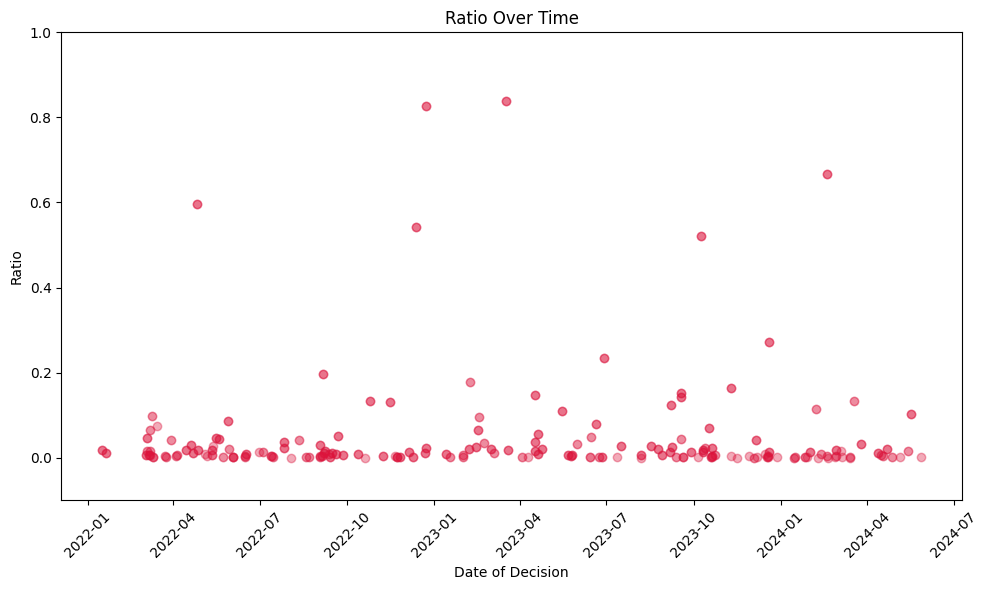

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

# Переводим время из формата April 10,2022 в 2022/02/24
new_exit_df['Date of Decision'] = pd.to_datetime(new_exit_df['Date of Decision'])

# Строим график, который показывает в какое-время с каким индексом компании выходили с рынка.
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.scatter(new_exit_df['Date of Decision'], new_exit_df['Ratio'], color='crimson', alpha=0.2)
plt.xlabel('Date of Decision')
plt.ylabel('Ratio')
plt.title('Ratio Over Time')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.ylim(-0.1, 1)

plt.show()

График не дает однозначный ответ, так как множество компаний изначально имели низкое соотношение прибылей в России и вне. Попробуем получить ответ численно, а не визуально.
Мы посчитаем медианное время ухода из России. Разделим компании на две категории по этому критерию и посчитаем среднее время ухода в обоих категориях.

In [210]:
# Выделяем дату отсчета дней - 24 февраля 2024 года. Создаем колонку days, которая показывает разницу между датой объявления об уходе из России и 24 февраля.
base_date = pd.Timestamp('2022-02-24')
new_exit_df['Days'] = (new_exit_df['Date of Decision'] - base_date).dt.days
new_exit_df

<ipython-input-210-7b140f7ae129>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['Days'] = (new_exit_df['Date of Decision'] - base_date).dt.days


,Company,Ratio,Date of Decision,Days
0,British American Tobacco,0.124208,2023-09-07,560
1,Veon,0.521229,2023-10-09,592
2,Renault Group,0.063881,2023-02-16,357
3,Danone,0.103218,2024-05-17,813
4,International Paper,0.152404,2023-09-18,571
...,...,...,...,...
1031,Infineon,0.000070,2023-11-16,630
1034,Nu Skin,0.000449,2023-04-10,410
1035,Srv,0.001014,2024-05-06,802
1036,Talgo,0.001701,2023-10-20,603


In [211]:
# Медианное значение ratio
median_ratio = new_exit_df['Ratio'].median()
median_ratio

0.012058045199395155

In [212]:
new_exit_df['AboveMedian'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > median_ratio else 'No')
average_days_above_median = new_exit_df[new_exit_df['AboveMedian'] == 'Yes']['Days'].mean()
average_days_below_median = new_exit_df[new_exit_df['AboveMedian'] == 'No']['Days'].mean()

<ipython-input-212-bd3e4c4067f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['AboveMedian'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > median_ratio else 'No')


In [213]:
average_days_above_median

384.841059602649

In [214]:
average_days_below_median

377.682119205298

Разница между двумя значениями незначительна, так как дней разницы меньше полумесяца((


⚡Возможно медиана просто является плохим показателем. Попробуем найти среднее для топ 10% компаний с высоким ratio и среднее для ботом 10% компаний с низким ratio. Может эти хвосты выборки дадут бОльшее различие в днях.

In [215]:
import pandas as pd

sorted_exit_df = new_exit_df.sort_values(by='Ratio', ascending=False)

# Используем функцию квантиль, чтобы выяснить значение ratio на этой позиции
top_10_percentile = sorted_exit_df['Ratio'].quantile(0.9)
lower_10_percentile = sorted_exit_df['Ratio'].quantile(0.10)

# Узнаем среднее значение дней по двум хвостам выборки
new_exit_df['In_top_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x >= top_10_percentile else 'No')
average_days_above_top_10 = new_exit_df[new_exit_df['In_top_10%'] == 'Yes']['Days'].mean()

new_exit_df['In_lower_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x <= lower_10_percentile else 'No')
average_days_below_top_10 = new_exit_df[new_exit_df['In_lower_10%'] == 'Yes']['Days'].mean()


<ipython-input-215-58a13716459b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['In_top_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x >= top_10_percentile else 'No')
<ipython-input-215-58a13716459b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['In_lower_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x <= lower_10_percentile else 'No')


In [ ]:
average_days_above_top_10

448.8225806451613

In [217]:
average_days_below_top_10

472.5245901639344

### ⭐ Теперь разница более существенна, но она противоречит гипотезе. Получается, что нельзя однозначно утвеждать, что зависимость от российской части бизнеса приводило к более позднему принятию решения.

## ⛳ Проверяем гипотезу 2: компаний из WEIRD стран (WEIRD = Western, educated, industrialized, rich and democratic) уходили активней, чем из не WEIRD стран.

У нас есть два датафрейма: с компаниями, которые ушли, и с компаниями, которые остаются в стране. Мы можем посчитать, сколько из каждой страны в датафреймах ушло и осталось компаний. Посчитать индекс "исхода" и сделать красивую карту, где интенсивность цвета будет обозначать близость индекса к единице.

In [218]:
import pandas as pd

# Считаем то, как часто страна появлялась в выгрузке
country_counts_stay = stay['Country'].value_counts().reset_index()
country_counts_stay.columns = ['Country', 'Count_stay']

# Сортируем датафрейм
country_counts_stay = country_counts_stay.sort_values(by='Country').reset_index(drop=True)
country_counts_stay

,Country,Count_stay
0,Afganistan,1
1,Argentina,1
2,Armenia,2
3,Australia,5
4,Austria,42
...,...,...
85,Ukraine,2
86,United Kingdom,80
87,Uzbekistan,7
88,Venezuela,1


In [219]:
# Также обрабатывает данные из датафрейма с ушедшими компаниями
country_counts_exit = exit_df['Country'].value_counts().reset_index()
country_counts_exit.columns = ['Country', 'Count_exit']
country_counts_exit = country_counts_exit.sort_values(by='Country').reset_index(drop=True)
country_counts_exit



,Country,Count_exit
0,,97
1,Australia,10
2,Austria,24
3,Azerbaijan,2
4,Belgium,4
5,Canada,14
6,Cyprus,13
7,Denmark,40
8,Estonia,3
9,Finland,82


Создаем два индекса: индекс исхода и индекс присутствия. Их мы будем использовать для окрашивания карты.

In [220]:
import pandas as pd


# Соединяем два датасета в один
merged_df = pd.merge(country_counts_stay, country_counts_exit, on='Country', how='outer')
merged_df.columns = ['Country', 'Count_stay', 'Count_exit']

# Рассчитываю индекс присутсвия как соотношение компаний, которые остались к общему количеству. Аналогично делаю с индексом исхода
merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.fillna(0)
merged_df['Total'] = merged_df['Count_stay'] + merged_df['Count_exit']
merged_df['Exodus Index'] = merged_df['Count_exit'] / merged_df['Total']
merged_df['Stay Index'] = -(merged_df['Count_stay'] / merged_df['Total'])

# Тут я создаю модифицирую индекс исхода. Если компаний который ушли нет, но есть информация по компаниям, которые остались, я считаю это как отрицательное значение индекса исхода.
merged_df['Exodus Index Modified'] = merged_df.apply(
    lambda row: row['Exodus Index'] if row['Exodus Index'] > 0 else row['Stay Index'], axis=1
)

merged_df



,Country,Count_stay,Count_exit,Total,Exodus Index,Stay Index,Exodus Index Modified
0,Afganistan,1.0,0.0,1.0,0.000000,-1.000000,-1.000000
1,Argentina,1.0,0.0,1.0,0.000000,-1.000000,-1.000000
2,Armenia,2.0,0.0,2.0,0.000000,-1.000000,-1.000000
3,Australia,5.0,10.0,15.0,0.666667,-0.333333,0.666667
4,Austria,42.0,24.0,66.0,0.363636,-0.636364,0.363636
...,...,...,...,...,...,...,...
87,Uzbekistan,7.0,0.0,7.0,0.000000,-1.000000,-1.000000
88,Venezuela,1.0,0.0,1.0,0.000000,-1.000000,-1.000000
89,Vietnam,1.0,0.0,1.0,0.000000,-1.000000,-1.000000
90,,0.0,97.0,97.0,1.000000,-0.000000,1.000000


Возникла проблема с тем, что название стран пакете геопандас не совпадает с тем, какие названия использовались на сайте. Я вручную сравнила названия из обоих датасетов, нашла 4 страны, которые отличаются в написании, и соответственно требуют замены имени.

In [221]:
row_index = merged_df.index[merged_df['Country'] == 'Afganistan'].tolist()
merged_df.loc[row_index, "Country"] = 'Afghanistan'

row_index = merged_df.index[merged_df['Country'] == 'Czechia'].tolist()
merged_df.loc[row_index, "Country"] = 'Czech Republic'

row_index = merged_df.index[merged_df['Country'] == 'UAE'].tolist()
merged_df.loc[row_index, "Country"] = 'United Arab Emirates'

row_index = merged_df.index[merged_df['Country'] == 'USA'].tolist()
merged_df.loc[row_index, "Country"] = 'United States of America'

merged_df = merged_df[merged_df['Country'] != 'Russia']

In [222]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Из геопандаса выгружаю формы стран для визуализации
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Соединяю два дата фрейма, чтобы можно было считывать и формы стран, и значения индексов.
world = world.merge(merged_df, how='left', left_on='name', right_on='Country')


<ipython-input-222-b5bec19dd234>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Рисуем карту:
- Белым помечаем страны, по которым нет информации.
- Оттенками синего страны, компании из которых скорее оставались в России.
- Оттенками красного страны, компании из которых скорее покидали Россию.

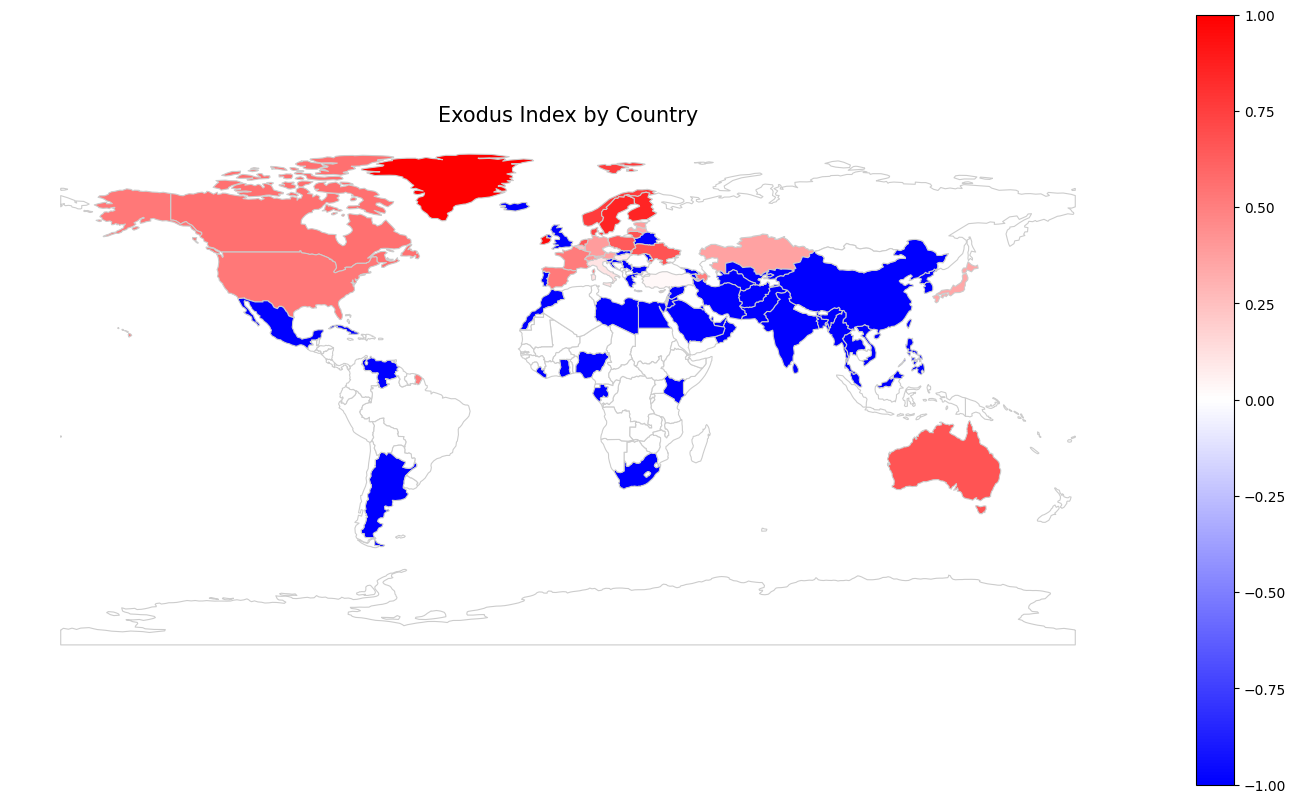

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
world.plot(column='Exodus Index Modified', cmap='bwr', linewidth=0.8, ax=ax, edgecolor='0.8',
           missing_kwds={'color': 'white'}, legend=True)
ax.set_title('Exodus Index by Country', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()
plt.show()

### ⭐ Методом пристального всматривания можем убедиться, что наша гипотеза оказалась верна. Большинство стран WEIRD, за исключением Великобритании, подсвечены красным, то есть компании из такищх стран активней уходили.

## ⛳ Проверяем гипотезу 3: Индустрия, в которой работает компания, существенно влияет на то, уйдет компания или нет, и как скоро. Компании, не из производственного/физического сектора уходят чаще и быстрее.

Особенности бизнеса в разных индустриях в теории могли влиять на то, как скоро компания могла покинуть рынок. Например, онлайн-сервис Нетфликс несет куда меньше потерь при уходе с рынка, чем производитель молочных продуктов Данон, поэтому Нетфликс ушел в первый год, а условный Данон только в 2023 году. В целом продавать физические объекты сложнее, чем сворачивать предприятие, которое состоит только из офиса для сотрудников, который чаще всего снимается в аренду.

In [224]:
import pandas as pd

def check(df):
    grouped = df.groupby('Industry')['Company'].apply(lambda x: list(x.unique()))
    max_length = grouped.apply(len).max()
    balanced_dict = {industry: company_list + [None] * (max_length - len(company_list))
                    for industry, company_list in grouped.items()}
    check = pd.DataFrame(balanced_dict)
    return check

# Для каждого типа компаний мы создаем датафрейм, где компании сгруппированы на основе их индустрии. Этот файл мы используем дальше, чтобы найти числа по каждой индустрии.
exited_by_industry = check(exit_df)
stay_by_industry = check(stay)
withdrawal_by_industry = check(withdrawal)

withdrawal_by_industry

,Advertising & PR,Aerospace,Agriculture,Air Transportation,Aircraft Industry,Alcohol & Tobacco,Analytics,Association & NGO,Automotive,Certification,...,Media,Metals & Mining,Online Services,Online Trading,Pharma & Healthcare,Public Catering,Sport,Technology,Telecom,Tourism & Travel
0,Bbdo,Incoff Aerospace,Olam Group,Fraport,Avitelos Prekyba Avitela And Elektromarkt,Anheuser Busch Inbev,Clarivate,American Kennel Club,Hyundai Motors,Bsi,...,Avid,Metinvest,Badoo,Etsy,Stada,Autogrill,Diamond League Iaaf,Avaya,Intracom Telecom,Best Western
1,Ddb,Moog Inc,Louis Dreyfus,Lufthansa,Cuav Tech Inc,J Germeister,Earthdaily Analytics,Bellona,Toyota Motor Corporation,None,...,Cbc,Tigers Realm Coal,Bolt,Its,Bristol Myers Squibb,Dominos Pizza,Elisa Esports,Fanuc,Mikenopa,Expedia
2,Interpublic Group,Superjet International,Agroterra,Aercap,Lufthansa Technik,Beam Suntory,None,Edelman,Jaguar Land Rover,None,...,Cyfrowy Polsat,Thyssenkrupp,Bumble,None,Eli Lilly,Dp Eurasia,European Boxing Union,Global Foundries,Cbs,Norwegian Cruise Lines
3,Leo Burnett,None,Agco,Air Lease,Meggitt,Edrington,None,Egmont Group,Mazda,None,...,Hearst,Weir Group,Edx,None,Orion Pharma,Hesburger,Formula One,John Wood Group,Vodafone,Oceania Cruises
4,None,None,Corteva Agriscience,Airbaltic,Qantas Airlines,Endeavour Group Dan Murphy S And Bws,None,Lloyds Register,Caterpillar,None,...,Iab Europe,Alcoa,Godaddy,None,Acino International Ag,Jamie Oliver Group,Ifsc,Kamstrup,None,Regent Seven Seas Cruises
5,None,None,Kramp Groep,Aircastle,None,Global Spirits,None,Organisation For The Prohibition Of Chemical W...,General Motors,None,...,J K Rowling,Aurubis Ag,Indrive,None,Bionorica,Marugame Seimen,International Boxing Federation,None,None,Tripadvisor
6,None,None,Klingspor,Airwork,None,Kalnapilis Taurus,None,Wikimedia Foundation Inc,Jaguar,None,...,Stephen King,Nucor Corp,Jobble,None,Biomarin,Ninja Sushi,International Cat Federation,None,None,Tui
7,None,None,Agrokoncernas,American Airlines,None,Nemiroff,None,None,Valeo,None,...,None,Rio Tinto,Letyshops,None,3Shape,None,International Cycling Union,None,None,Windstar Cruises
8,None,None,Buhler Industries,Cargologicair,None,Stoli Group,None,None,Iveco,None,...,None,Sociedade Mineira De Catoca,Medium,None,Agilent Technologies,None,International Ice Hockey Federation,None,None,None
9,None,None,None,Chapman Freeborn,None,Suntory,None,None,Lear Corporation,None,...,None,Tata Steel,Myfitnesspal,None,Avantor,None,International Weightlifting Federation,None,None,None


In [225]:
def return_numb_by_industry(df):
    industry_counts = []

    # Узнаем, сколько компаний есть в каждой индустрии
    for industry in df.columns:
        company_count = df[industry].notnull().sum()
        industry_counts.append({'Industry': industry, 'Number of Companies': company_count})

    # Создаем базу данных с информацией по всем индустриям
    industry_counts_df = pd.DataFrame(industry_counts)
    return industry_counts_df

exit_vertical_industry = return_numb_by_industry(exited_by_industry)
stay_vertical_industry = return_numb_by_industry(stay_by_industry)
withdrawal_vertical_industry = return_numb_by_industry(withdrawal_by_industry)
withdrawal_vertical_industry

,Industry,Number of Companies
0,Advertising & PR,4
1,Aerospace,3
2,Agriculture,9
3,Air Transportation,15
4,Aircraft Industry,5
5,Alcohol & Tobacco,14
6,Analytics,2
7,Association & NGO,7
8,Automotive,20
9,Certification,1


In [226]:
# Объединяем все три датафрейма в один, чтобы на его основе сделать столбчатую диаграмму.

merged_data = pd.merge(exit_vertical_industry, withdrawal_vertical_industry, on='Industry', how='outer').merge(stay_vertical_industry, on='Industry', how='outer')
merged_data.columns = ['Industry', 'Exited', 'Withdrawed', 'Stayed']
merged_data

,Industry,Exited,Withdrawed,Stayed
0,Advertising & PR,6.0,4.0,7.0
1,Aerospace,1.0,3.0,28.0
2,Agriculture,6.0,9.0,38.0
3,Alcohol & Tobacco,5.0,14.0,14.0
4,Analytics,4.0,2.0,2.0
5,Automotive,36.0,20.0,81.0
6,Chemical Industry,17.0,15.0,51.0
7,Construction & Architecture,19.0,10.0,50.0
8,Consulting & Law,13.0,25.0,27.0
9,Consumer Goods & Clothing,26.0,34.0,125.0


Пишем код, чтобы сделать столбчатую диаграмму с накоплением. Она должна наглядно показать много или мало компаний уходило в какой-то индустрии относительно других индустрий.

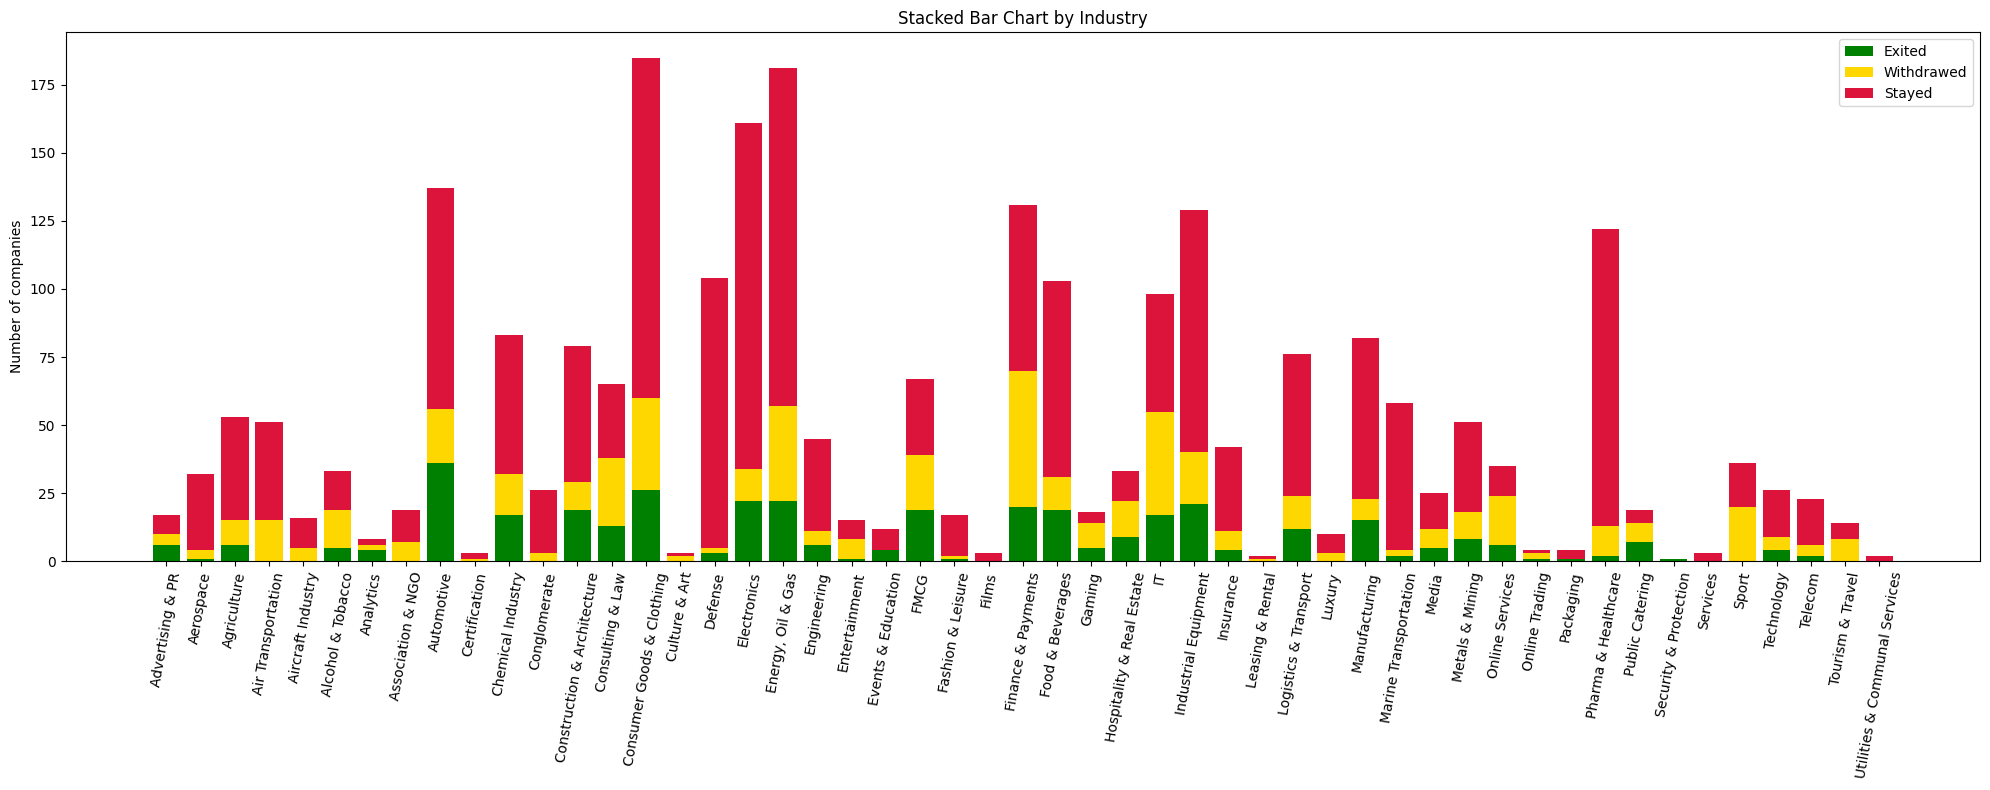

In [229]:
grouped_data = merged_data.groupby('Industry').sum()
fig, ax = plt.subplots(figsize=(20, 8))

# Определяем основные параметры графика
industries = grouped_data.index
bar_width = 0.8
indices = range(len(industries))

# Будем помечать ушедшие компании зеленым, уходящие - желтым, а остающиеся красым.
p1 = plt.bar(indices, grouped_data['Exited'], bar_width, color='green', label='Exited')
p2 = plt.bar(indices, grouped_data['Withdrawed'], bar_width, bottom=grouped_data['Exited'], color='gold', label='Withdrawed')
p3 = plt.bar(indices, grouped_data['Stayed'], bar_width, bottom=grouped_data['Exited'] + grouped_data['Withdrawed'], color='crimson', label='Stayed')


plt.ylabel('Number of companies')
plt.title('Stacked Bar Chart by Industry')
plt.xticks(indices, industries, rotation=80)
plt.legend()

plt.tight_layout()
plt.show()


График получился интересным, но общую картину увидеть сложновато. Заменим желтым на зеленый. Будем считать, что раз компания попала в категорию withdrawal по классификации KSE Institute, она практически ушла с рынка.
Также уменьшим количество индустрий, убрав те, где нет одного из компонентов: stay, withdraw или exit.

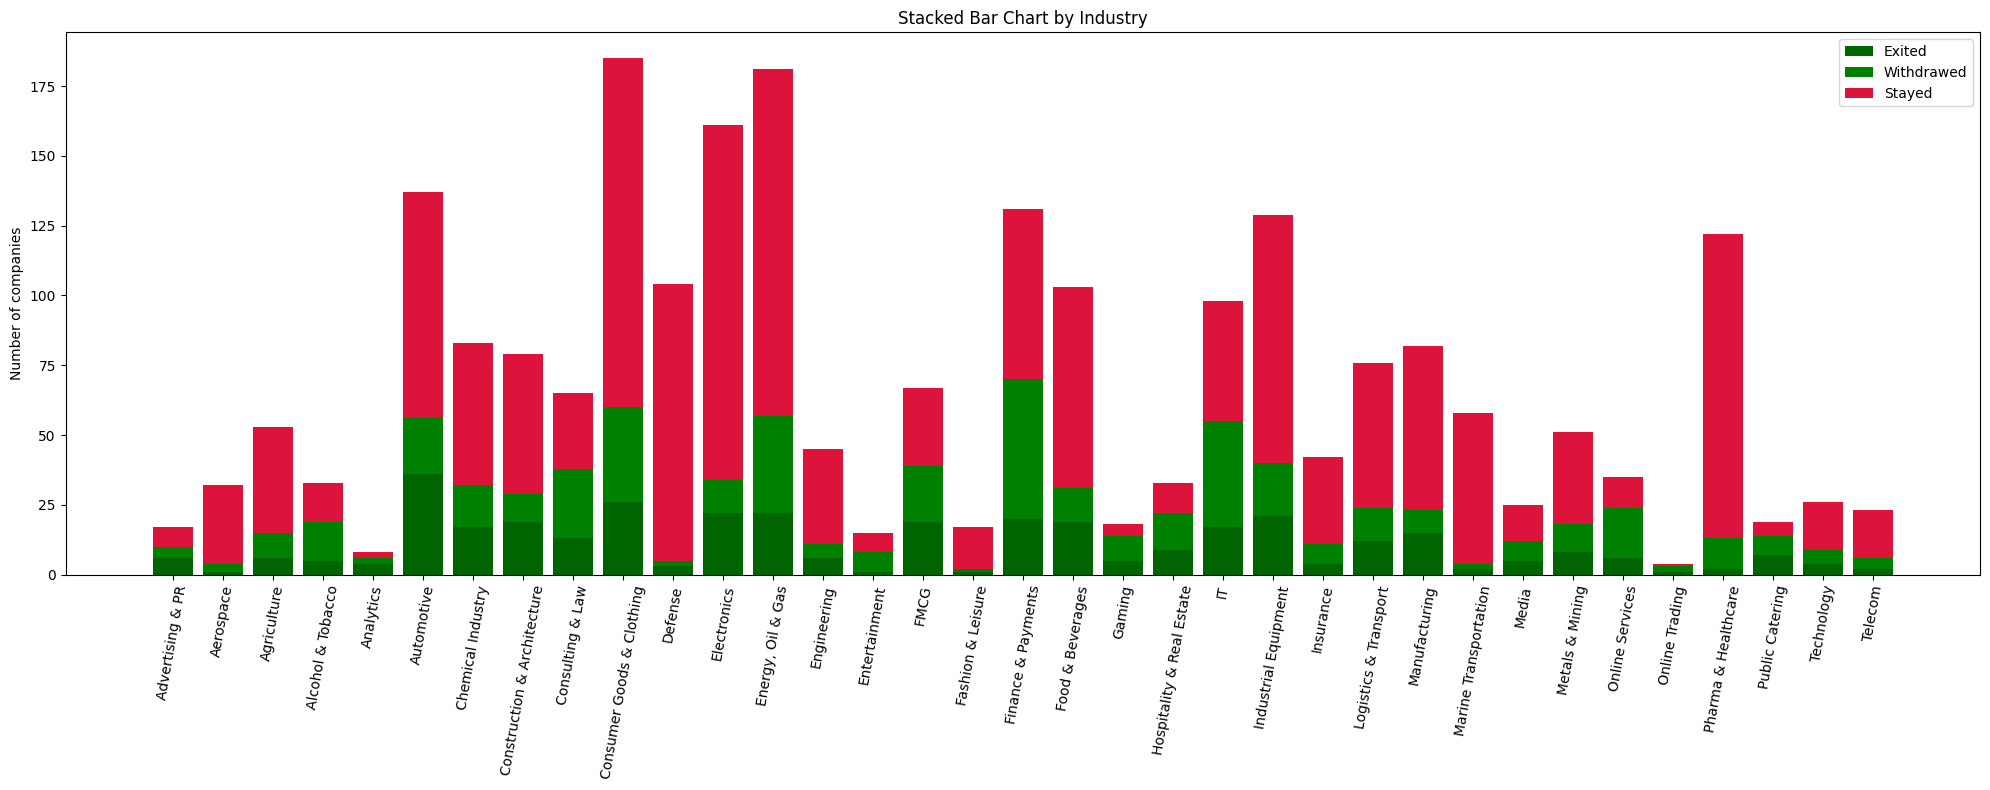

In [228]:
# Очищаем от пустых значений
new_merged_data = merged_data.dropna()

grouped_data = new_merged_data.groupby('Industry').sum()
fig, ax = plt.subplots(figsize=(20, 8))

industries = grouped_data.index
bar_width = 0.8
indices = range(len(industries))

p1 = plt.bar(indices, grouped_data['Exited'], bar_width, color='darkgreen', label='Exited')
p2 = plt.bar(indices, grouped_data['Withdrawed'], bar_width, bottom=grouped_data['Exited'], color='green', label='Withdrawed')
p3 = plt.bar(indices, grouped_data['Stayed'], bar_width, bottom=grouped_data['Exited'] + grouped_data['Withdrawed'], color='crimson', label='Stayed')

plt.ylabel('Number of companies')
plt.title('Stacked Bar Chart by Industry')
plt.xticks(indices, industries, rotation=80)
plt.legend()

plt.tight_layout()
plt.show()

### ⭐ Теперь посмотрим, где соотношение зеленого к красного в пределах около 50%.
- Это индустрии: Advertising & PR, Consulting & Law, Analytics, Entertainment, Finance & Payments, Gaming, IT, Media, Online Services, Online Trading. Они все зачастую не требуют больших вложений в физические активы, потому что их услуги предоставляются онлайн или они создают нефизические продукты.  

- Также соотношение около 50% имели индустрии FMCG,Public Catering, Alkohol&Tobacco, Hospitality and Real Estate, хотя они продают именно физические продукты или нуждаются в помещениях/здниях/складах/торговых площадках.

- Большая разница наблюдается в Consumer Goods & Clothing, Defense, Electronics, Energy Oil & Gas, Engineering, Fashion and Leisure, Food and Beverages, Telecom, Technology, Pharma, Industrial Equipment, Manufacturing и другие. Многие из этих индустрий имеют непосредственное отношение к промышленности.

Получается, что гипотеза имеет отражение в данных, но, видимо, также имеются другие факторы, которые существенно влияют на выбор компаний.